## This notebook shows 3 difference tools that the propagator needs for the simulation

1. convert between different coordinates frames using astropy
2. Compute communication windows (when is the satellite visible from a ground station?)
3. Compute eclipse windows (when is the earth blocking the satellite from receiving sunlight?)

In [13]:
import numpy as np

from astropy.coordinates import (
    GCRS,
    ITRS,
    CartesianRepresentation,
    SphericalRepresentation,
    get_body_barycentric_posvel,
)
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.time import Time

from poliastro.earth.plotting import GroundtrackPlotter

from poliastro.bodies import Earth, Sun

from poliastro.core.events import eclipse_function

In [2]:
# load a trajectory
file_name = "1day.npy"
traj = np.load("propagation_results/position_vel_" + file_name)
rr = traj[:, :3]
vv = traj[:, 3:]

epochs = np.load("propagation_results/epochs_" + file_name, allow_pickle=True)

## 1. Convert between different coordinate frames

### A. Convert to lat-lon coordinates (ITRS frame, spherical representation)

In [3]:
raw_xyz = CartesianRepresentation(rr, xyz_axis=-1)
raw_obstime = epochs
gcrs_xyz = GCRS(
    raw_xyz, obstime=raw_obstime, representation_type=CartesianRepresentation
)

# Converts raw coordinates to ITRS ones.
itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=raw_obstime))
itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)
print(itrs_latlon)

[(2.44004748, 0.00272874, 6928.1366    ),
 (2.43982988, 0.00381396, 6928.13659429),
 (2.43961228, 0.00489918, 6928.13657714), ...,
 (0.09285098, 1.43376478, 6921.60952591),
 (0.08502598, 1.43348859, 6921.60615336),
 (0.07723236, 1.43320428, 6921.60278845)] (rad, rad, )


### B. Go the other way around

In [4]:
itrs_cartesian = itrs_latlon.represent_as(CartesianRepresentation)

# Create ITRS object using the cartesian representation
itrs_xyz2 = ITRS(itrs_cartesian, obstime=raw_obstime)

# Transform from ITRS back to GCRS
gcrs_xyz2 = itrs_xyz2.transform_to(GCRS(obstime=raw_obstime))

print((gcrs_xyz2.data.xyz - gcrs_xyz.data.xyz) < 0.00001)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


## 2. Check if a satellite is visible from a ground station

In [5]:
station_coords = [46.31, 6.38] * u.deg  # [LAT LON]
station_name = "Lausanne"
satellite_name = "CHESS_1"

In [6]:
# First, plot the groundtrack to be able to check results later

gp = GroundtrackPlotter()
gp.add_trace(
    go.Scattergeo(
        lat=station_coords[0],
        lon=station_coords[1],
        name=station_name,
        marker={"color": "red"},
        showlegend=True,
    )
)
gp.add_trace(
    go.Scattergeo(
        lat=itrs_latlon.lat.to(u.deg),
        lon=itrs_latlon.lon.to(u.deg),
        mode="lines",
        name=satellite_name,
        line={"color": "purple", "width": 1},
    )
)
# Customize plots
gp.update_layout(
    margin=dict(l=10, r=10, b=0, t=50),  # Set margins to zero
    height=500,
    width=800,
    legend=dict(
        title="Legend:",
        orientation="h",  # Horizontal legend
        yanchor="bottom",  # Anchor to the bottom
        y=-0,  # Position it below the plot (adjust as needed)
        xanchor="center",  # Center the legend
        x=0.5,  # Center the legend horizontally
    ),
)
gp.fig.show()
gp.update_geos(projection_type="orthographic")
gp.fig.show()

In [7]:
earth_R = Earth.R.to(u.km)  # Earth's radius (km)

# Step 1: Create a SphericalRepresentation
spherical_coords = SphericalRepresentation(
    lat=station_coords[0],
    lon=station_coords[1],
    distance=earth_R,  # Earth's average radius + height
)

# Step 2: Convert to CartesianRepresentation
cartesian_coords = spherical_coords.represent_as(CartesianRepresentation)
# print(cartesian_coords)
cartesian_coords = np.tile(
    cartesian_coords.xyz, (len(epochs), 1)
)  # repeat it for the number of epochs
# print(cartesian_coords)
cartesian_coords = CartesianRepresentation(cartesian_coords, xyz_axis=-1)
# print(cartesian_coords)

# Step 3: Specify obstime for ITRS
obstime = epochs

# Step 4: Instantiate the ITRS object
itrs_object = ITRS(cartesian_coords, obstime=obstime)

# print(itrs_object)

# Step 5: Transform from ITRS back to GCRS
gcrs_object = itrs_object.transform_to(GCRS(obstime=obstime))

print(gcrs_object.data.xyz)

[[-3015.89533713 -3015.661996   -3015.42863878 ... -1004.73780934
  -1004.42521853 -1004.11262231]
 [-3199.72669826 -3199.94753051 -3200.16834574 ... -4286.5903148
  -4286.6644877  -4286.73863781]
 [ 4620.25441509  4620.25378265  4620.25315016 ...  4614.78839123
   4614.78753991  4614.78668858]] km


In [8]:
print(np.transpose(gcrs_object.data.xyz.value).shape)

(7201, 3)


In [9]:
# print distance between satellite and trajectory
satellite_coords = np.array(rr)
gs_coords = np.array(np.transpose(gcrs_object.data.xyz.value))
print(satellite_coords.shape)
print(gs_coords.shape)

distance_vec = satellite_coords - gs_coords  # numpy broadcast
print(distance_vec.shape)
# print(gs_coords.shape)


def angle_between_vectors(A, B):
    """
    Calculates the angle (in degrees) between corresponding 3D vectors
    in matrices A and B. Each row represents a vector in 3D space.

    Parameters:
    A : np.ndarray
        Matrix of shape (n, 3) representing n 3D vectors.
    B : np.ndarray
        Matrix of shape (n, 3) representing n 3D vectors.

    Returns:
    np.ndarray
        A vector of shape (n,) containing the angles (in degrees) between corresponding vectors.
    """
    # Dot product of corresponding rows in A and B
    dot_product = np.einsum("ij,ij->i", A, B)

    # Norm (magnitude) of vectors in A and B
    norm_A = np.linalg.norm(A, axis=1)
    norm_B = np.linalg.norm(B, axis=1)

    # Cosine of the angle
    cos_theta = dot_product / (norm_A * norm_B)

    # Clip to avoid numerical errors leading to values outside the range [-1, 1]
    cos_theta = np.clip(cos_theta, -1.0, 1.0)

    # Calculate the angle in radians and then convert to degrees
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)

    return angle_deg


# example to understand: this algorithm always return positive value between 0 and 180 degrees
# since the "range" is symmetrix with the ground station (elevation angle), this is not a problem here
u = np.array([[1, 0], [0, 1], [1, -1]])
v = np.array([[1, 0]])
angle_deg = angle_between_vectors(u, v)
# print(angle_deg)

(7201, 3)
(7201, 3)
(7201, 3)


94.19815125020078


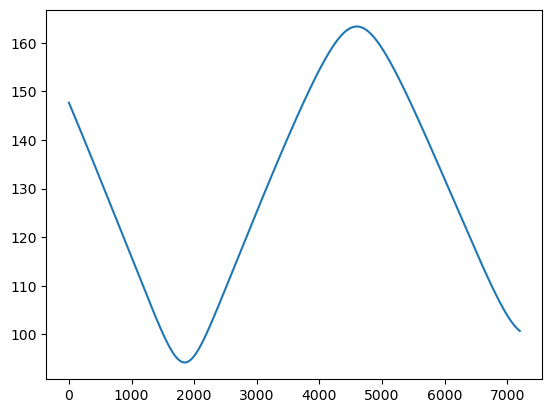

In [10]:
angles = angle_between_vectors(distance_vec, gs_coords)
print(min(angles))
plt.plot(angles)
plt.show()

## 3. Compute eclipse window
Notes from poliastro function:
- The shadow function is taken from Escobal, P. (1985). Methods of orbit determination.
- The current implementation assumes circular bodies and doesn't account for flattening.

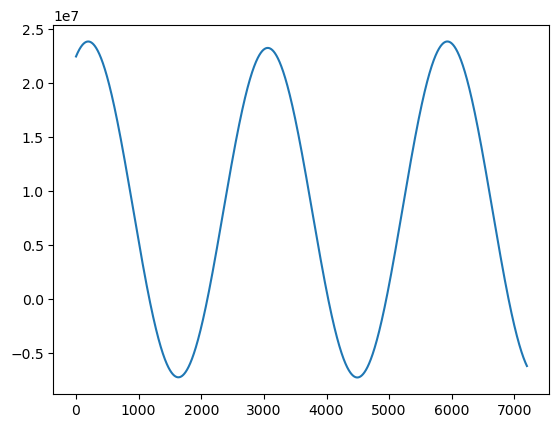

In [20]:
k = Earth.k.to_value(u.km**3 / u.s**2)
R_sec = Sun.R.to_value(u.km)
R_pri = Earth.R.to_value(u.km)

eclipses = []
for i in range(len(epochs)):
    epoch = epochs[i]
    r = rr[i]
    v = vv[i]

    # Position vector of Sun wrt Solar System Barycenter
    r_sec_ssb = get_body_barycentric_posvel("Sun", epoch)[0]
    r_pri_ssb = get_body_barycentric_posvel("Earth", epoch)[0]

    r_sec = ((r_sec_ssb - r_pri_ssb).xyz << u.km).value
    # print(r_sec)

    eclipse = eclipse_function(k, np.hstack((r, v)), r_sec, R_sec, R_pri, umbra=False)
    eclipses.append(eclipse)

plt.plot(eclipses)
plt.show()